# Notebook to compare/analyse cloud masks

> **ACM (Auto Cloud Mask)**: <font color=blue> Automated Cloud Mask generated automatically by EarthDailyAgro in less than 1 min</font>

> **HQco (High Quality Manual Cloud Mask)**: <font color=blue> Automated Cloud Mask corrected by EarthDaily Agro or his HQco cloud mask provider (20min of work at least) </font>


### @author: EarthDaily Agro

In [2]:
# import libraries

import os
import glob
from osgeo import gdal
import geopandas as gpd
import rasterio
import pandas as pd
import numpy as np
from rasterio.features import geometry_mask
from rasterstats import zonal_stats
import matplotlib.pyplot as plt

## Data on local

### Mask ACM
> **Label 0** : `no_data`

> **Label 1** : `clear`

> **Label 2** : `cloud`

In [3]:
# Define folders and intersect ACM rasters with fields

# Folder path
path = "***"

# cloud masks folder
raster_path = path+"/Masks"

# Get all rasters in the cloud masks folder
tiff = "*.tif"

# Fields
fields = path+"/Fields/Fields_WGS84.shp"

# Browse sub-directories
for folder in os.listdir(raster_path):
    path_folder = os.path.join(raster_path, folder)
    
    # Check if the path is a folder
    if os.path.isdir(path_folder):
        rasters_files = glob.glob(os.path.join(path_folder, tiff))
    
    for raster in rasters_files: 
        print(raster)
        gdf = gpd.read_file(fields)
        
        # Path to original raster
        input_raster_path = raster
        
        # Path to the output raster
        output_raster_path = raster_path+"/raster_repro.tif"

        # Target projection (EPSG:4326)
        target_projection = 'EPSG:4326'

        # Open original raster
        raster_ds = gdal.Open(input_raster_path)

        # Use gdal.Warp to reproject the raster to EPSG:4326
        gdal.Warp(output_raster_path, raster_ds, dstSRS=target_projection)

        gdf['mean'] = pd.DataFrame(
            zonal_stats(
                vectors=gdf['geometry'], 
                raster=output_raster_path, 
                stats='mean'))
        #print(np.mean(gdf["mean"]))
        
        image_name = raster.split("\\")
        new_colunm = image_name[2][:-8]
        gdf["image_name"] = new_colunm
       
        gdf_clear = gdf[gdf['mean'] == 1]
        #print(np.mean(gdf_clear["mean"]))
        
        # Save the updated GeoDataFrame in the shapefile
        output_shapefile_path_clear = path+"/Results_ACM/"+new_colunm+"_acm_clear.shp"
        gdf_clear.to_file(output_shapefile_path_clear)
        #print(image_name[2][:-8])
        
        gdf_cloud = gdf[gdf['mean'] > 1]
        #print(np.mean(gdf_cloud["mean"]))
        
        # Sauvegarder le GeoDataFrame mis à jour dans le shapefile
        output_shapefile_path_cloud =path+"/Results_ACM/"+new_colunm+"_acm_cloud.shp"
        gdf_cloud.to_file(output_shapefile_path_cloud)
        print(image_name[2][:-8])        


C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Masks\20230116\L8_203024_20230116_utm30_gs2_acm.tif
L8_203024_20230116_utm30_gs2
C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Masks\20230116\L8_203024_20230116_utm30_gs2_acm.tif
L8_203024_20230116_utm30_gs2
C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Masks\20230116\L8_203024_20230116_utm30_gs2_acm.tif
L8_203024_20230116_utm30_gs2


In [4]:
# Merge ACM results

# Path to shapefile directory
path_shp_results = path+"/Results_ACM"

# Pattern to get clear shapefile in the folder
shp_clear = "*clear.shp"

# Use glob to obtain a list of shapefiles
fields_acm = glob.glob(f"{path_shp_results}/{shp_clear}")
merged_gdf = gpd.read_file(fields_acm[0])

# Loop through the rest of the shapefiles and append them
for path_acm in fields_acm[1:]:
    gdf = gpd.read_file(path_acm)
    merged_gdf = merged_gdf.append(gdf, ignore_index=True)

    # Save the merged shapefile
merged_gdf.to_file(path_shp_results+"/merged_fields_clear_acm.shp")
print(path_shp_results+"/merged_fields_clear_acm.shp")
    
# Pattern to get cloud shapefile in the folder
shp_cloud = "*cloud.shp"

# Utilisation de glob pour obtenir une liste des fichiers shapefile
fields_acm = glob.glob(f"{path_shp_results}/{shp_cloud}")
merged_gdf = gpd.read_file(fields_acm[0])

# Loop through the rest of the shapefiles and append them
for path_acm in fields_acm[1:]:
    gdf = gpd.read_file(path_acm)
    merged_gdf = merged_gdf.append(gdf, ignore_index=True)

    # Save the merged shapefile
merged_gdf.to_file(path_shp_results+"/merged_fields_cloud_acm.shp")
print(path_shp_results+"/merged_fields_cloud_acm.shp")

C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Results_ACM/merged_fields_clear_acm.shp
C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Results_ACM/merged_fields_cloud_acm.shp


### Mask HQco
> **clear** : `clear`

> **cloud** : `cloud`

In [5]:
# Define folders and intersect HQco shapefiles with fields

# cloud masks folder
cloud_mask = path+"/Masks"

# fields
fields = path+"/Fields/Fields_WGS84.shp"

# Get all shapefiles in the cloud masks folder
pattern = "*.shp"

# Browse sub-directories
for folder in os.listdir(cloud_mask):
    path_folder = os.path.join(cloud_mask, folder)
    
    # Check if the path is a folder
    if os.path.isdir(path_folder):
        files_shapefile = glob.glob(os.path.join(path_folder, pattern))
        
        # Show files found in this folder
        for file in files_shapefile:
            # Read shapefiles into GeoDataFrames
            gdf1 = gpd.read_file(file)
            gdf2 = gpd.read_file(fields)
            # Reproject cloud mask
            gdf1_reprojected = gdf1.to_crs(gdf2.crs)
            # Perform the intersection
            intersection_result = gpd.overlay(gdf1_reprojected, gdf2, how='intersection')
            # Save the result to a new shapefile
            image_name = file.split("\\")
            print(image_name[2][:-10])
            new_colunm = image_name[2][:-10]
            intersection_result["image_name"] = new_colunm
            intersection_result.to_file(path+"/Results_HQco/"+image_name[2])
            print(file)

L8_203024_20230116_utm30_gs2
C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Masks\20230116\L8_203024_20230116_utm30_gs2_clear.shp
L8_203024_20230116_utm30_gs2
C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Masks\20230116\L8_203024_20230116_utm30_gs2_cloud.shp


In [6]:
# Merge HQco results

# Path to shapefile directory
path_shapefiles = path+"/Results_HQco"

# Pattern to get shapefile in the folder
clear = "*_clear.shp"
cloud = "*_cloud.shp"

# Use glob to obtain a list of shapefiles
fields_clear = glob.glob(f"{path_shapefiles}/{clear}")
fields_cloud = glob.glob(f"{path_shapefiles}/{cloud}")

merged_gdf = gpd.read_file(fields_clear[0])

# Loop through the rest of the shapefiles and append them
for shp_clear in fields_clear[1:]:
    gdf = gpd.read_file(shp_clear)
    merged_gdf = merged_gdf.append(gdf, ignore_index=True)

    # Save the merged shapefile
merged_gdf.to_file(path_shapefiles+"/merged_fields_clear_hqco.shp")
print(path_shapefiles+"/merged_fields_clear_hqco.shp")

# Read the first shapefile to set the schema
merged_gdf = gpd.read_file(fields_cloud[0])

# Loop through the rest of the shapefiles and append them
for shp_cloud in fields_cloud[1:]:
    gdf = gpd.read_file(shp_cloud)
    merged_gdf = merged_gdf.append(gdf, ignore_index=True)

    # Save the merged shapefile
merged_gdf.to_file(path_shapefiles+"/merged_fields_cloud_hqco.shp")
print(path_shapefiles+"/merged_fields_cloud_hqco.shp")

C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Results_HQco/merged_fields_clear_hqco.shp
C:/Users/mal/Desktop/Studies-and-Analysis-main/Auto-Cloud-Mask-Accuracy/Results_HQco/merged_fields_cloud_hqco.shp


In [7]:
# Update merged shapefile with new colunm "code"
cloud_hqco = gpd.read_file(path+"/Results_HQco/merged_fields_cloud_hqco.shp")
cloud_hqco = cloud_hqco.drop(columns='geometry')
#cloud_hqco["idseasonfi"] = cloud_hqco["idseasonfi"].astype(np.object)
code = cloud_hqco["idseasonfi"].astype(str)+'_'+cloud_hqco["image_name"]
cloud_hqco["code"] = code
print(cloud_hqco)

cloud_acm = gpd.read_file(path+"/Results_ACM/merged_fields_cloud_acm.shp")
cloud_acm = cloud_acm.drop(columns='geometry')
cloud_acm['idseasonfi'] = cloud_acm['idseasonfi'].apply(lambda x: str(x))
code = cloud_acm["idseasonfi"].astype(str)+'_'+cloud_acm["image_name"]
cloud_acm["code"] = code
print(cloud_acm)

clear_acm = gpd.read_file(path+"/Results_ACM/merged_fields_clear_acm.shp")
clear_acm = clear_acm.drop(columns='geometry')
code = clear_acm["idseasonfi"].astype(str)+'_'+clear_acm["image_name"]
clear_acm["code"] = code
print(clear_acm)
                          
clear_hqco = gpd.read_file(path+"/Results_HQco/merged_fields_clear_hqco.shp")
clear_hqco = clear_hqco.drop(columns='geometry')
clear_hqco['idseasonfi'] = clear_hqco['idseasonfi'].apply(lambda x: str(x))
code = clear_hqco["idseasonfi"].astype(str)+'_'+clear_hqco["image_name"]
clear_hqco["code"] = code
print(clear_hqco)

      id  idseasonfi                    image_name  \
0    NaN         112  L8_203024_20230116_utm30_gs2   
1    NaN         113  L8_203024_20230116_utm30_gs2   
2    NaN         114  L8_203024_20230116_utm30_gs2   
3    NaN         115  L8_203024_20230116_utm30_gs2   
4    NaN         116  L8_203024_20230116_utm30_gs2   
..   ...         ...                           ...   
926  0.0        5768  L8_203024_20230116_utm30_gs2   
927  0.0        5769  L8_203024_20230116_utm30_gs2   
928  0.0        5770  L8_203024_20230116_utm30_gs2   
929  0.0        5771  L8_203024_20230116_utm30_gs2   
930  0.0        5772  L8_203024_20230116_utm30_gs2   

                                  code  
0     112_L8_203024_20230116_utm30_gs2  
1     113_L8_203024_20230116_utm30_gs2  
2     114_L8_203024_20230116_utm30_gs2  
3     115_L8_203024_20230116_utm30_gs2  
4     116_L8_203024_20230116_utm30_gs2  
..                                 ...  
926  5768_L8_203024_20230116_utm30_gs2  
927  5769_L8_203024_202

### Join ACM and HQco results & compute metrics

In [8]:
# Perform the join operation

clear_clear = clear_hqco.merge(clear_acm, on='code', how='left')
clear_clear = clear_clear[clear_clear['mean']==1]
#print(clear_clear)
#print(len(clear_clear))
cloud_clear = cloud_hqco.merge(clear_acm, on='code', how='left')
cloud_clear = cloud_clear[cloud_clear['mean']==1]
#print(cloud_clear)
#print(len(cloud_clear))
clear_cloud = clear_hqco.merge(cloud_acm, on='code', how='left')
clear_cloud = clear_cloud[clear_cloud['mean']>1]
#print(clear_cloud)
#print(len(clear_cloud))
cloud_cloud = cloud_hqco.merge(cloud_acm, on='code', how='left')
cloud_cloud = cloud_cloud[cloud_cloud['mean']>1]
#print(cloud_cloud)
#print(len(cloud_cloud))

# Metrics - Number of fields clear and cloud in ACM and HQco

ACM_clear=len(clear_acm)
print('Number of fields clear in ACM = '+str(ACM_clear))
HQco_clear=len(clear_hqco)
print('Number of fields clear in HQco = '+str(HQco_clear))
ACM_cloud=len(cloud_acm)
print('Number of fields cloud in ACM = '+str(ACM_cloud))
HQco_cloud=len(cloud_hqco)
print('Number of fields cloud in HQco = '+str(HQco_cloud))

print('Number of fields clear in HQco and ACM = '+str(len(clear_clear)))
print('Number of fields clear in ACM and cloud in HQco = '+str(len(cloud_clear)))
print('Number of fields clear in HQco and cloud in ACM = '+str(len(clear_cloud)))
print('Number of fields cloud in HQco and ACM = '+str(len(cloud_cloud)))

# Sum of fields

sum_fields = ACM_clear + ACM_cloud
print('Total number of fields = ' +str(sum_fields))

Number of fields clear in ACM = 221
Number of fields clear in HQco = 1
Number of fields cloud in ACM = 5734
Number of fields cloud in HQco = 931
Number of fields clear in HQco and ACM = 0
Number of fields clear in ACM and cloud in HQco = 128
Number of fields clear in HQco and cloud in ACM = 1
Number of fields cloud in HQco and ACM = 803
Total number of fields = 5955


In [9]:
# Compute percent metrics

clear_clear_final = len(clear_acm) - len(cloud_clear)
cloud_clear_final = len(cloud_clear)
clear_cloud_final = len(clear_cloud)
cloud_cloud_final = len(cloud_acm) - len(clear_cloud)
clear_clear_percent = np.round(clear_clear_final / sum_fields * 100)
cloud_clear_percent = np.round(cloud_clear_final / sum_fields * 100)
clear_cloud_percent = np.round(clear_cloud_final / sum_fields * 100)
cloud_cloud_percent = np.round(cloud_cloud_final / sum_fields * 100)
print('Percent of fields clear in HQco and ACM = '+str(np.round(clear_clear_percent))+'%')
print('Percent of fields clear in ACM and cloud in HQco = '+str(np.round(cloud_clear_percent))+'%')
print('Percent of fields clear in HQco and cloud in ACM = '+str(np.round(clear_cloud_percent))+'%')
print('Percent of fields cloud in HQco and ACM = '+str(np.round(cloud_cloud_percent))+'%')
def sum_eda(*args):
    return sum(args)
sum_eda(np.round(clear_clear_percent),np.round(cloud_clear_percent),np.round(clear_cloud_percent),np.round(cloud_cloud_percent))

Percent of fields clear in HQco and ACM = 2.0%
Percent of fields clear in ACM and cloud in HQco = 2.0%
Percent of fields clear in HQco and cloud in ACM = 0.0%
Percent of fields cloud in HQco and ACM = 96.0%


100.0

### Plot metrics - compute matrix confusion

Analysis of ACM vs HQco: 
accuracy 98.0%, over cloud detection 0.0%, under cloud detection 2.0%


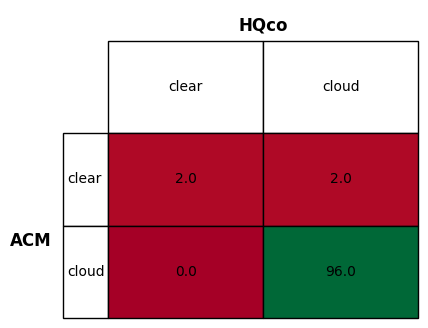

In [10]:
# Plot metrics

# Column and row names
column_names = ['clear', 'cloud']
row_names = ['clear', 'cloud']

mat_confusion = np.array([[clear_clear_percent, cloud_clear_percent], [clear_cloud_percent, cloud_cloud_percent]])

# Create dataframe
df = pd.DataFrame(mat_confusion, index=row_names, columns=column_names)

# Plot
plt.figure(figsize=(4, 4))
plt.axis('off')

plt.text(0.5, 0.95, 'HQco', fontsize=12, fontweight='bold', ha='center', va='center')
plt.text(-0.25, 0.25, 'ACM', fontsize=12, fontweight='bold', ha='center', va='center')

# Plot confusion matrix
tableau = plt.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, cellLoc='center', loc='center',
                        cellColours=plt.cm.RdYlGn(df.values / np.max(df.values)), bbox=[0, 0, 1, 0.9])

tableau.auto_set_font_size(False)
tableau.set_fontsize(10)
tableau.scale(1, 1.5)

# compute accuracy, over/under cloud detection
accuracy = mat_confusion[0, 0] + mat_confusion[1, 1]
over_detection = mat_confusion[1, 0]
under_detection = mat_confusion[0, 1]
print("Analysis of {} vs {}: \naccuracy {}%, over cloud detection {}%, under cloud detection {}%".format('ACM','HQco',accuracy,over_detection,under_detection))

plt.show()